### S&P500 VIX Analysis

In [1]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import utils

load_dotenv()
file_path = os.getenv("FILE_PATH")
SNP_VIX_file = f'{file_path}/S&P 500 VIX.csv'

In [2]:
# Load the CSV file into df
VIX = pd.read_csv(SNP_VIX_file)
VIX.columns = ["vol"]
VIX["log_vol_diff"] = np.log(VIX['vol']/ VIX['vol'].shift(1))
VIX.index = pd.to_datetime(VIX.index)
VIX = VIX.sort_index(ascending=True)
VIX = VIX[1:]
VIX['log_vol'] = np.log(VIX['vol'])

VIX.head()

,vol,log_vol_diff,log_vol
2015-01-05,19.92,-0.058496,2.991724
2015-01-06,21.12,0.089597,3.050220
2015-01-07,19.31,0.126822,2.960623
2015-01-08,17.01,-0.031253,2.833801
2015-01-09,17.55,-0.110476,2.865054


In [3]:
# vix_training_start, vix_training_end = "2015-01-02", "2022-12-30"
vix_training_start, vix_training_end = "2018-01-01", "2020-06-30"
vix_testing_start, vix_testing_end = "2020-07-01", "2020-08-01"

vix_training_df = VIX[(VIX.index >= vix_training_start) & (VIX.index <= vix_training_end)]
vix_testing_df = VIX[(VIX.index >= vix_testing_start) & (VIX.index <= vix_testing_end)]
vix_training_df.head()

,vol,log_vol_diff,log_vol
2018-01-02,9.77,0.065563,2.279316
2018-01-03,9.15,-0.007621,2.213754
2018-01-04,9.22,0.000000,2.221375
2018-01-05,9.22,-0.032020,2.221375
2018-01-08,9.52,-0.057158,2.253395


In [4]:
from hurst import compute_Hc

vix_hurst_est, c, data = compute_Hc(vix_training_df["log_vol"], kind='change', simplified=True)
print(f"Estimated Hurst Exponent: {vix_hurst_est:.4f}")

Estimated Hurst Exponent: 0.6277


In [5]:
# Aggregated variance method

def hurst_aggregated_variance(series, min_window=10, max_window=None):
    """
    Estimate the Hurst exponent using Aggregated Variance method.
    
    Parameters:
    series : array-like
        The time series data.
    min_window : int
        Minimum window size.
    max_window : int or None
        Maximum window size (default is len(series) // 2).
    
    Returns:
    float
        Estimated Hurst exponent.
    """
    if max_window is None:
        max_window = len(series) // 2

    windows = np.logspace(np.log10(min_window), np.log10(max_window), num=20, dtype=int)
    var_values = []

    for w in windows:
        segments = [series[i:i+w] for i in range(0, len(series) - w, w)]
        segment_means = [np.mean(seg) for seg in segments]
        var_values.append(np.var(segment_means))

    log_var = np.log(var_values)
    log_n = np.log(windows[:len(log_var)])

    H, _ = np.polyfit(log_n, log_var, 1)  # Slope is 2H - 2
    return (H + 2) / 2

# Example Usage:
hurst_estimate_var = hurst_aggregated_variance(vix_training_df['log_vol'])
print(f"Estimated Hurst exponent (Aggregated Variance): {hurst_estimate_var}")

Estimated Hurst exponent (Aggregated Variance): 0.34803462555340936


In [6]:
from stochastic.processes.continuous import FractionalBrownianMotion
import numpy as np
import random
import plotly.graph_objects as go

def simulate_fbm_vix(train_data, test_data, H):
    """
    Simulates a VIX path using geometric fractional Brownian motion.
    
    Parameters:
        train_data (DataFrame): Training data containing at least 'vol' and 'log_vol_diff'.
        test_data (DataFrame): Testing data to determine the simulation length.
        H (float): Hurst exponent for the fractional Brownian motion.
        
    Returns:
        np.ndarray: Simulated VIX values.
    """
    # Set fixed seeds for reproducibility
    random.seed(42)
    np.random.seed(42)

    # Calculate drift (μ) and volatility (σ) from training log differences of VIX
    mu = train_data["log_vol_diff"].mean()
    sigma = train_data["log_vol_diff"].std()

    n_days = len(test_data)
    # Define and sample from the fBM model
    fbm = FractionalBrownianMotion(hurst=H, t=n_days-1)
    fbm_values = fbm.sample(n=n_days-1)

    # Use the last available VIX value in training data as the starting point
    S0 = train_data['vol'].iloc[-1]
    # Simulate the VIX path using a geometric fBM model
    simulated_vix = S0 * np.exp(mu * np.arange(n_days) + sigma * fbm_values)
    print(mu, sigma)
    return simulated_vix

def plot_fbm_vix(test_data, simulated_vix, H):
    """
    Plots actual vs. simulated VIX values.
    
    Parameters:
        test_data (DataFrame): Testing data containing actual VIX values under 'vol'.
        simulated_vix (np.ndarray): Simulated VIX values.
        H (float): Hurst exponent used in the simulation (for labeling purposes).
    """
    fig = go.Figure()

    # Actual VIX trace
    fig.add_trace(go.Scatter(
        x=test_data.index,
        y=test_data["vol"],
        mode='lines',
        name='Actual VIX',
        line=dict(color='blue')
    ))

    # Forecasted VIX trace using fBM
    fig.add_trace(go.Scatter(
        x=test_data.index,
        y=simulated_vix,
        mode='lines',
        name='Forecasted VIX (fBM)',
        line=dict(color='red', dash='dash')
    ))

    # Update layout of the plot
    fig.update_layout(
        title=f"VIX Forecast using fBM (H={H})",
        xaxis_title="Date",
        yaxis_title="VIX Value",
        template="plotly_white"
    )

    fig.show()

# Example usage:
simulated_vix = simulate_fbm_vix(vix_training_df, vix_testing_df, vix_hurst_est)
plot_fbm_vix(vix_testing_df, simulated_vix, vix_hurst_est)

-0.0017060147747200226 0.09294785307769589


In [7]:
import pandas as pd
import numpy as np
from hurst import compute_Hc

def compute_rolling_hurst(df, window, col='log_vol_diff', lag=0):
    hurst_values = []
    times = []
    
    # Loop through the DataFrame using the rolling window
    for i in range(window - 1, len(df), lag+1):
        # Extract the window slice from the series
        window_series = df[col].iloc[i - window + 1 : i + 1: lag+1]
        # Compute the Hurst exponent using the 'change' method and simplified calculation
        h, c, data = compute_Hc(window_series, kind='change', simplified=True)
        
        hurst_values.append(h)
        times.append(df.index[i])
    
    # Create and return a new DataFrame with the computed Hurst exponents
    result_df = pd.DataFrame({'hurst': hurst_values}, index=times)
    return result_df

rolling_hurst_150 = compute_rolling_hurst(VIX, window=150, col='log_vol', lag=0)
rolling_hurst_350 = compute_rolling_hurst(VIX, window=300, col='log_vol', lag=0)
rolling_hurst_500 = compute_rolling_hurst(VIX, window=500, col='log_vol', lag=0)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=rolling_hurst_150.index,
    y=rolling_hurst_150["hurst"],
    mode='lines',
    name='150 days rolling window',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=rolling_hurst_350.index,
    y=rolling_hurst_350["hurst"],
    mode='lines',
    name='350 days rolling window',
    line=dict(color='red')
))
fig.add_trace(go.Scatter(
    x=rolling_hurst_500.index,
    y=rolling_hurst_500["hurst"],
    mode='lines',
    name='500 days rolling window',
    line=dict(color='green')
))
fig.update_layout(
    title=f"Hurst exponent for volatility",
    xaxis_title="Date",
    yaxis_title="Hurst Value",
    template="plotly_white"
)

In [8]:
# Setup object
vix_training_data_obj = utils.VixDf(vix_training_df)

# Simulate 1 day
next_day_pred = utils.simulate_fbm_ndays(vix_training_data_obj, 0.3, 1)
print(f'Next day prediction: {next_day_pred}')

# Attempts to predict 5 days
utils.apply_rolling_function(vix_training_data_obj, 500, 5)
print(f'Next 5 days prediction: {next_day_pred}')

Next day prediction: [31.0186887]
Next 5 days prediction: [31.0186887]


In [9]:
vix_training_data_obj.get_df().head()

,vol,log_vol_diff,log_vol
2018-01-02,9.77,0.065563,2.279316
2018-01-03,9.15,-0.007621,2.213754
2018-01-04,9.22,0.000000,2.221375
2018-01-05,9.22,-0.032020,2.221375
2018-01-08,9.52,-0.057158,2.253395


In [10]:
vix_obj = utils.VixDf(VIX)
result_df = utils.apply_rolling_predictions_from_start(vix_obj, '2022-01-01', 150)
result_df.head()

,predicted
2021-05-28,19.328732
2021-06-01,18.926286
2021-06-02,20.803496
2021-06-03,19.715266
2021-06-04,16.112733


In [11]:
merged_df = result_df.join(VIX, how='inner')
merged_df.head()

,predicted,vol,log_vol_diff,log_vol
2021-05-28,19.328732,16.76,-0.065806,2.818995
2021-06-01,18.926286,17.90,0.023743,2.884801
2021-06-02,20.803496,17.48,-0.031534,2.861057
2021-06-03,19.715266,18.04,0.094091,2.892592
2021-06-04,16.112733,16.42,0.000000,2.798500


In [12]:
import numpy as np

def compute_rmse(df, predicted_col='predicted', actual_col='vol'):
    diff = df[predicted_col] - df[actual_col]
    mse = np.mean(diff ** 2)
    rmse = np.sqrt(mse)
    return rmse

compute_rmse(merged_df)

2.9802282132616136

In [13]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=merged_df.index,
    y=merged_df["predicted"],
    mode='lines',
    name='Predicted',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=merged_df.index,
    y=merged_df["vol"],
    mode='lines',
    name='Actual',
    line=dict(color='red')
))
fig.update_layout(
    title=f"Predicted vs Actual Volatility",
    xaxis_title="Date",
    yaxis_title="Volatility",
    template="plotly_white"
)

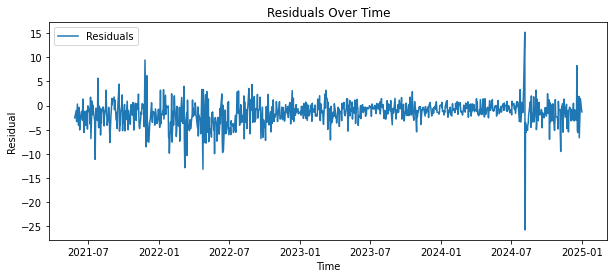

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

# Example DataFrame: df should already have a time series index and the columns 'observed' and 'predicted'
# df = pd.read_csv('your_data.csv', index_col='date', parse_dates=True)

# 1. Compute the residuals
df = merged_df 
df['residual'] = df['vol'] - df['predicted']

# 2. Plot the residuals over time
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['residual'], label='Residuals')
plt.title("Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.legend()
plt.show()

Observations:
- Occasional large spikes, indicating outliers 
- Residuals oscillate around zero (good)
- No obvious trend

c:\Users\joshu\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



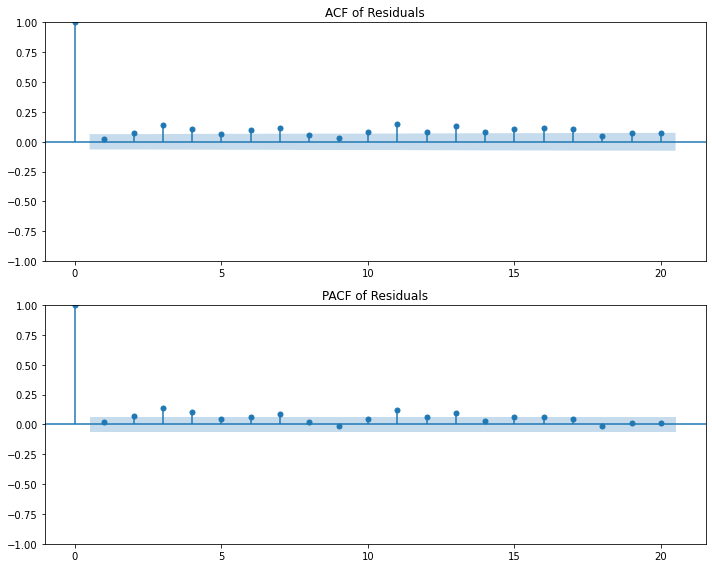

In [15]:

# 3. Plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df['residual'], lags=20, ax=ax[0])
plot_pacf(df['residual'], lags=20, ax=ax[1])
ax[0].set_title("ACF of Residuals")
ax[1].set_title("PACF of Residuals")
plt.tight_layout()
plt.show()

Observations:
- No signification autocorrelation (since no spikes), captured temporal dependencies well
- Good fit

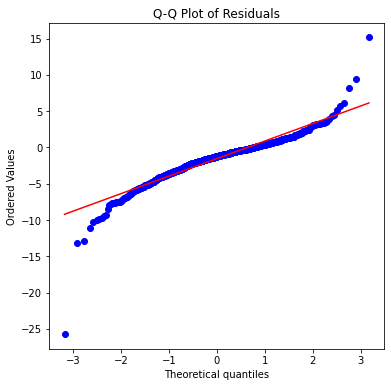

In [16]:
# 4. Q-Q Plot for normality check of the residuals
plt.figure(figsize=(6, 6))
stats.probplot(df['residual'], dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

Observations:
- Observed heavy tails, indicating that there are outliers
- Non-normal distribution, (probably t distribution)

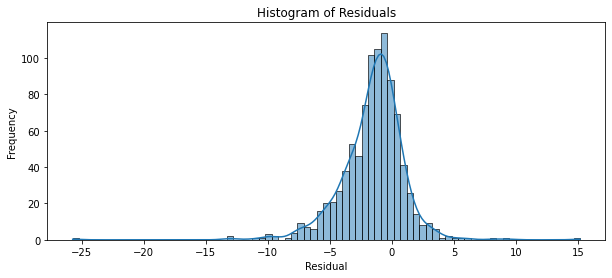

In [17]:
# 5. Histogram of the residuals
plt.figure(figsize=(10, 4))
sns.histplot(df['residual'], kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

In [18]:
# 6. Perform a normality test (Shapiro-Wilk Test)
stat, p_value = stats.shapiro(df['residual'])
print(f'Shapiro-Wilk Test statistic: {stat:.4f}, p-value: {p_value:.4f}')


Shapiro-Wilk Test statistic: 0.9004, p-value: 0.0000
